# Strategic Risk Management - Chapter 1
### Campbell Harvey, Sandy Rattray, Otto Van Hermert

In [1]:
import os
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import nasdaqdatalink
import quantstats as qs
from scipy import interpolate
from scipy import ndimage
import datetime as dt
import bt
import scipy as sp

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

## Data 

In [2]:
ticks = yf.Tickers('spy ief lqd gld')
df = ticks.history(period='max')
df = df['Close']
df = df.dropna(how='any', axis=0)

[*********************100%***********************]  4 of 4 completed


#### Resampling

In [3]:
df = df.resample('BM').last()

#### Returns

In [5]:
rets_df = np.log(df/df.shift(1))
rets_df = rets_df.dropna(how='all', axis=0)

In [6]:
rets_df

GLD       IEF       LQD       SPY
Date                                              
2004-12-31 -0.029692  0.011605  0.013814  0.029677
2005-01-31 -0.036740  0.008674  0.012209 -0.022676
2005-02-28  0.030556 -0.013778 -0.009406  0.020688
2005-03-31 -0.016445 -0.004043 -0.012703 -0.018462
2005-04-29  0.012301  0.024854  0.016086 -0.018913
...              ...       ...       ...       ...
2021-10-29  0.014689 -0.004439  0.005296  0.067811
2021-11-30 -0.006925  0.010862 -0.001187 -0.008067
2021-12-31  0.032458 -0.005254 -0.000342  0.045210
2022-01-31 -0.016930 -0.021357 -0.036580 -0.054183
2022-02-28  0.052328 -0.011105 -0.030560 -0.035473

[207 rows x 4 columns]

In [7]:
cumrets_df = rets_df.cumsum()

In [18]:
fig = go.Figure()

for col in cumrets_df.columns:
    fig.add_trace(go.Scatter(x=cumrets_df.index, y=cumrets_df[col], name=col))
    
fig.update_layout(
    title=f"Cumulative returns for all 4 ETFs ({cumrets_df.index[0].strftime('%B %Y')} - " \
          +                f"{cumrets_df.index[-1].strftime('%B %Y')})"
)

fig.show()

In [32]:
fig = go.Figure()

for col in cumrets_df.columns:
    fig.add_trace(go.Scatter(x=cumrets_df.index, y=(100*(1+rets_df).cumprod())[col], name=col))
    
fig.update_layout(
    title=f"Equity curves for all 4 ETFs ({cumrets_df.index[0].strftime('%B %Y')} - " \
          +                f"{cumrets_df.index[-1].strftime('%B %Y')})"
)

fig.show()

### Momentum

Momentum signal defined as:

$mom_{t-1} = \frac{w_1 R_{t-1} + w_2 R_{t-2} + ...}{\sigma_{t-1} \sqrt{w_1^2 + w_2^2 + ...}}$

with $R_{t-1}$ the return at time t-1 and w the weight on that return. According to the authors the term $\sqrt{w_1^2 + w_2^2 + ...}$ is to achieve a unit stdev.

In [45]:
mom_df = rets_df.copy(deep=True)

In [125]:
### Single month momentum
max_lag = 12
vol_lookback = 12
all_moms = []

rolling_std = np.sqrt(12)*rets_df.rolling(vol_lookback).std().shift().dropna()

for l in range(1,max_lag+1):
    temp_df = rets_df.shift(l) / rolling_std
    all_moms.append(temp_df.dropna())

In [66]:
### Performance
perf_df = rets_df.copy(deep=True)

vol_target = 0.1
scaledRets_df = rets_df * (vol_target / rolling_std)
k = vol_target / (scaledRets_df.dropna().std()*np.sqrt(12))

perf_df = scaledRets_df * all_moms[0].shift(1) / rolling_std.shift(1)

<AxesSubplot:xlabel='Date'>

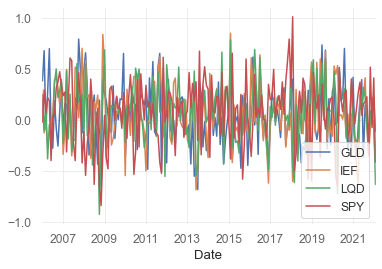

In [68]:
all_moms[0].plot()

In [69]:
all_moms[0].sum(axis=1)

Date
2005-12-30    1.185366
2006-01-31    0.796663
2006-02-28    0.743642
2006-03-31    0.133747
2006-04-28   -0.155438
                ...   
2021-10-29   -1.121422
2021-11-30    0.594043
2021-12-31    0.079059
2022-01-31    0.513977
2022-02-28   -1.571531
Freq: BM, Length: 195, dtype: float64

In [128]:
test= all_moms[0].copy(deep=True)

In [129]:
test

GLD       IEF       LQD       SPY
Date                                              
2005-12-30  0.436916  0.114275  0.141889  0.492286
2006-01-31  0.381711  0.246814  0.190972 -0.022834
2006-02-28  0.677942 -0.127862 -0.100794  0.294356
2006-03-31 -0.077689 -0.019583  0.159102  0.071917
2006-04-28  0.257138 -0.248827 -0.382201  0.218451
...              ...       ...       ...       ...
2021-10-29 -0.192657 -0.330244 -0.244342 -0.354179
2021-11-30  0.085712 -0.093347  0.085508  0.516170
2021-12-31 -0.042677  0.220570 -0.024436 -0.074397
2022-01-31  0.217339 -0.106541 -0.007045  0.410224
2022-02-28 -0.115344 -0.409164 -0.632387 -0.414637

[195 rows x 4 columns]

## Scale signal

If we follow the methodology outlined we get a position sizes that can wipe out our entire portfolio (e.g in plot below). An idea would be to scale the signal to get:
- if there are short signals:
    - the combined short weights should be equal to -10% of portfolio value
    - if there are long signals we scale their weights to 90% and put the remaining 10% in cash for margin (assume 100% collat.)
    - if there are no long signals we put 100% in cash
- if there are only long signals their combined weights have to be equal to 100%

In [83]:
s = bt.Strategy('Momemtum (1-month lag)', [bt.algos.SelectAll(),
                      bt.algos.WeighTarget(test),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, df)
res = bt.run(t)

In [84]:
res.display()

Stat                 Momemtum (1-month lag)
-------------------  ------------------------
Start                2004-11-29
End                  2022-02-28
Risk-free rate       0.00%

Total Return         -1.78%
Daily Sharpe         0.11
Daily Sortino        0.18
CAGR                 -0.10%
Max Drawdown         -27.50%
Calmar Ratio         -0.00

MTD                  -0.12%
3m                   2.77%
6m                   2.31%
YTD                  -0.04%
1Y                   2.50%
3Y (ann.)            1.49%
5Y (ann.)            2.00%
10Y (ann.)           1.46%
Since Incep. (ann.)  -0.10%

Daily Sharpe         0.11
Daily Sortino        0.18
Daily Mean (ann.)    3.97%
Daily Vol (ann.)     35.08%
Daily Skew           -0.11
Daily Kurt           2.08
Best Day             8.33%
Worst Day            -8.79%

Monthly Sharpe       0.02
Monthly Sortino      0.04
Monthly Mean (ann.)  0.19%
Monthly Vol (ann.)   7.67%
Monthly Skew         -0.11
Monthly Kurt         2.05
Best Month           8.33%
Wors

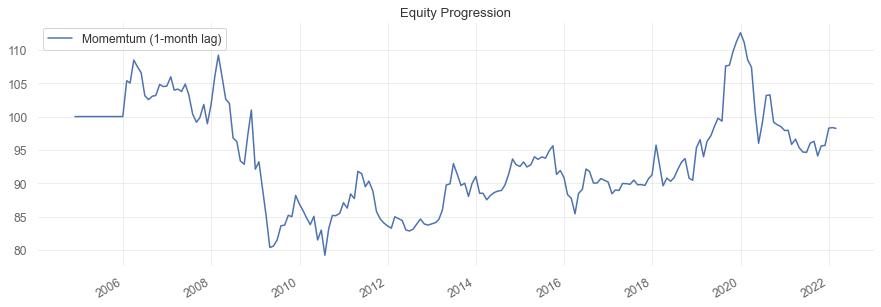

In [85]:
res.plot()
plt.show()

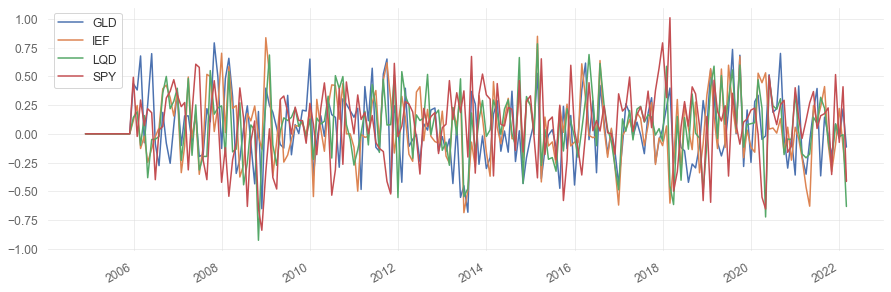

In [86]:
res.plot_security_weights()
plt.show()

In [130]:
for i in range(test.shape[0]):
    scaling = 1.0
    if len(np.where(test.iloc[i,:]<0)[0]):
        test.iloc[i,np.where(test.iloc[i,:]<0)[0]] = -0.1*test.iloc[i,np.where(test.iloc[i,:]<0)[0]]/test.iloc[i,np.where(test.iloc[i,:]<0)[0]].sum()
        scaling = 1.1
    if len(np.where(test.iloc[i,:]>0)[0]):
        test.iloc[i,np.where(test.iloc[i,:]>0)[0]] = scaling * test.iloc[i,np.where(test.iloc[i,:]>0)[0]]/test.iloc[i,np.where(test.iloc[i,:]>0)[0]].sum()


In [131]:
test.sum(axis=1)

Date
2005-12-30    1.0
2006-01-31    1.0
2006-02-28    1.0
2006-03-31    1.0
2006-04-28    1.0
             ... 
2021-10-29   -0.1
2021-11-30    1.0
2021-12-31    1.0
2022-01-31    1.0
2022-02-28   -0.1
Freq: BM, Length: 195, dtype: float64

In [133]:
s = bt.Strategy('Scaled Weights Momemtum (1-month lag)', [bt.algos.SelectAll(),
                      bt.algos.WeighTarget(test),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, df)
res = bt.run(t)

In [134]:
res.display()

Stat                 Scaled Weights Momemtum (1-month lag)
-------------------  ---------------------------------------
Start                2004-11-29
End                  2022-02-28
Risk-free rate       0.00%

Total Return         131.23%
Daily Sharpe         2.40
Daily Sortino        4.32
CAGR                 4.98%
Max Drawdown         -26.53%
Calmar Ratio         0.19

MTD                  -0.34%
3m                   1.96%
6m                   7.66%
YTD                  -2.26%
1Y                   17.14%
3Y (ann.)            13.14%
5Y (ann.)            12.10%
10Y (ann.)           7.04%
Since Incep. (ann.)  4.98%

Daily Sharpe         2.40
Daily Sortino        4.32
Daily Mean (ann.)    112.68%
Daily Vol (ann.)     47.02%
Daily Skew           0.24
Daily Kurt           2.18
Best Day             13.91%
Worst Day            -7.95%

Monthly Sharpe       0.52
Monthly Sortino      0.94
Monthly Mean (ann.)  5.39%
Monthly Vol (ann.)   10.28%
Monthly Skew         0.24
Monthly Kurt         2.1

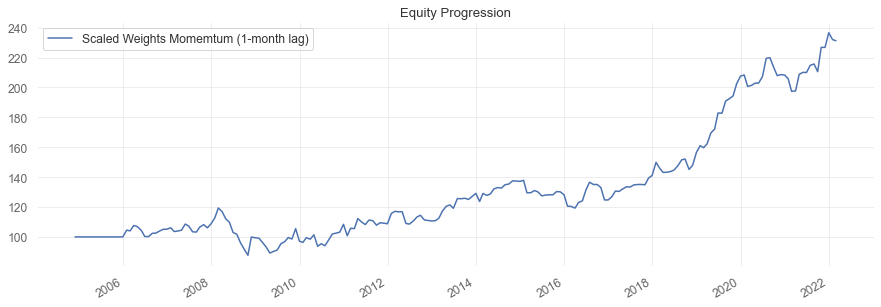

In [135]:
res.plot()
plt.show()

<AxesSubplot:>

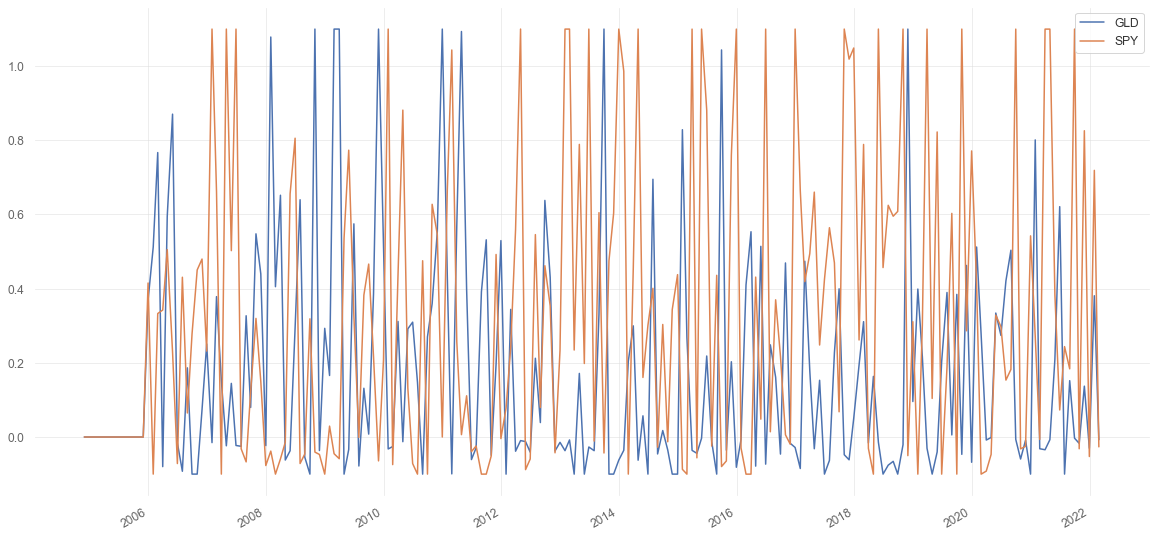

In [144]:
res.get_security_weights()[['GLD', 'SPY']].plot(figsize=(20,10))

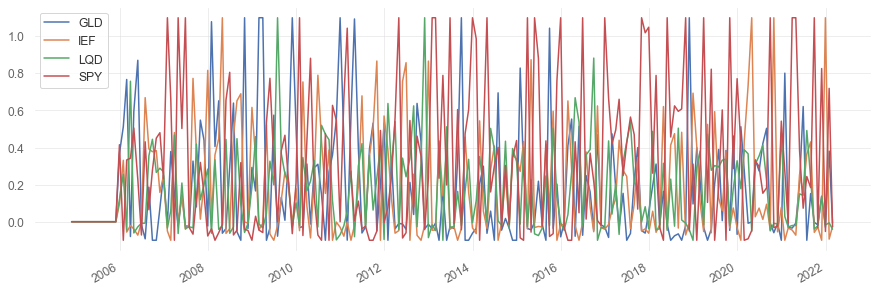

In [136]:
res.plot_security_weights()
plt.show()

### Checking backtest

In [147]:
tick = yf.Ticker('spy')
spy_df = tick.history(period='max')
spy_df = spy_df['Close']
spy_df = spy_df.dropna(how='any', axis=0)

In [190]:
s = bt.Strategy('S&P 500 Buy and HODL', [bt.algos.SelectAll(),
                                         bt.algos.WeighEqually(),
                                         bt.algos.LimitDeltas(),
                                         bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, pd.DataFrame(spy_df))
res = bt.run(t)

In [193]:
import inspect
lines = inspect.getsource(t.strategy.prices.calc_perf_stats())
print(lines)


def calc_perf_stats(prices):
    """
    Calculates the performance statistics given an object.
    The object should be a Series of prices.

    A PerformanceStats object will be returned containing all the stats.

    Args:
        * prices (Series): Series of prices

    """
    return PerformanceStats(prices)



In [196]:
t.strategy.prices.calc_perf_stats().

In [150]:
res.display()

Stat                 S&P 500 Buy and HODL
-------------------  ----------------------
Start                1993-01-28
End                  2022-02-18
Risk-free rate       0.00%

Total Return         1594.37%
Daily Sharpe         0.61
Daily Sortino        0.97
CAGR                 10.23%
Max Drawdown         -55.19%
Calmar Ratio         0.19

MTD                  -3.49%
3m                   -7.23%
6m                   -0.46%
YTD                  -8.58%
1Y                   12.62%
3Y (ann.)            18.03%
5Y (ann.)            14.97%
10Y (ann.)           14.45%
Since Incep. (ann.)  10.23%

Daily Sharpe         0.61
Daily Sortino        0.97
Daily Mean (ann.)    11.50%
Daily Vol (ann.)     18.72%
Daily Skew           -0.06
Daily Kurt           12.08
Best Day             14.52%
Worst Day            -10.94%

Monthly Sharpe       0.74
Monthly Sortino      1.26
Monthly Mean (ann.)  10.84%
Monthly Vol (ann.)   14.60%
Monthly Skew         -0.61
Monthly Kurt         1.22
Best Month           1

Main reason for checking is that our data is in monthly frequency but provides daily stats.

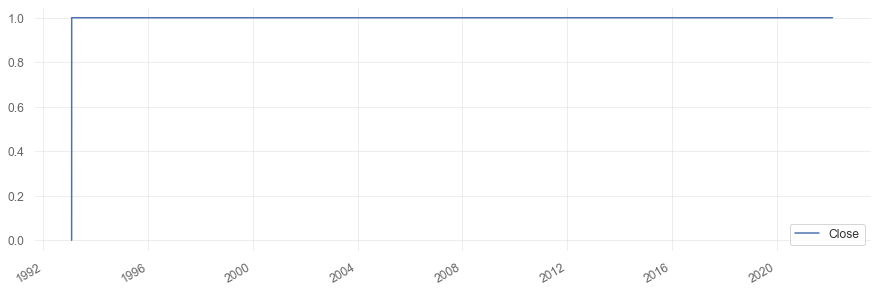

In [151]:
res.plot_security_weights()

In [160]:
### Price returns (no divs)
spy_df.iloc[-1]/spy_df.iloc[0] - 1

### Mean monthly returns
np.mean((spy_df/spy_df.shift(1))**12 - 1)

0.01484621147634686

In [165]:
spy_df_monthly = spy_df.resample('M').last()

In [205]:
spy_df

Date
1993-01-29     25.627356
1993-02-01     25.809607
1993-02-02     25.864302
1993-02-03     26.137707
1993-02-04     26.247051
                 ...    
2022-02-14    439.019989
2022-02-15    446.100006
2022-02-16    446.600006
2022-02-17    437.059998
2022-02-18    434.230011
Name: Close, Length: 7319, dtype: float64

In [206]:
((spy_df/spy_df.shift(1) - 1).mean())*252

0.11501393293714163

In [201]:
((spy_df.resample('M').last()/spy_df.resample('M').last().shift(1) - 1).mean())*12

0.10844799649844145

In [200]:
((spy_df.resample('Y').last()/spy_df.resample('Y').last().shift(1) - 1).mean())

0.11498705304197007

### Volatility Scaling

In [43]:
vol_target = 0.05

scaledRets_df = rets_df * (vol_target / rolling_std)

In [44]:
k = vol_target / (scaledRets_df.dropna().std()*np.sqrt(12))